In [1]:
# ! ls model_weights

In [2]:
# load weights: is this the model weight for the stacked datasets? 
# "ftw-3class-full_unet-efficientnetb3_rgbnir_1ba4e1bd.pth"

In [3]:
# from src.ftw.trainers import CustomSemanticSegmentationTask


# model = CustomSemanticSegmentationTask(
#         model = "unet",
#         backbone = "efficientnet-b3",
#         weights = True,
#         in_channels = 4,
#         num_classes = 3,
#         num_filters = 3,
#         loss  = "ce",
#         class_weights  = [0.04, 0.08, 0.88], # read from config
#         ignore_index = 3,
#         lr = 1e-3,
#         patience= 100,
#         patch_weights = False,
#         freeze_backbone = True,
#         freeze_decoder = False,
#     ) 

In [1]:
# import segmentation_models_pytorch as smp
# import torch

# model = smp.Unet(
#     encoder_name="efficientnet-b3",
#     encoder_weights=None,
#     in_channels=4,
#     classes=3
# )
# # model.load_state_dict(torch.load("model_weights/ftw-3class-full_unet-efficientnetb3_rgbnir_1ba4e1bd.pth", weights_only=True))
# pretrained = torch.load("model_weights/ftw-3class-full_unet-efficientnetb3_rgbnir_1ba4e1bd.pth")

# # Remove first conv weights (usually 'encoder.conv_stem.0.weight')
# pretrained = {k: v for k, v in pretrained.items() if not k.startswith('encoder.conv_stem.0')}

# model.load_state_dict(pretrained, strict=False)


In [1]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

# Load checkpoint
checkpoint = torch.load("model_weights/ftw-3class-full_unet-efficientnetb3_rgbnir_1ba4e1bd.pth")

# Remove _conv_stem.weight
checkpoint.pop("encoder._conv_stem.weight", None)

model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=4,  # 4 channels
    classes=3
)

# Load everything else
missing, unexpected = model.load_state_dict(checkpoint, strict=False)

print(f"Missing keys: {missing}")
print(f"Unexpected keys: {unexpected}")

# Reinitialize first conv layer manually (if you want better initialization)
with torch.no_grad():
    nn.init.kaiming_normal_(model.encoder._conv_stem.weight, mode='fan_out', nonlinearity='relu')


Missing keys: ['encoder._conv_stem.weight']
Unexpected keys: []


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      4, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [3]:
device

device(type='cuda')

In [4]:
# adapter 
# import torch.nn as nn


# old_conv = model.encoder._conv_stem

# # Replace it with a new conv accepting 4 channels
# new_conv = nn.Conv2d(
#     in_channels=4,
#     out_channels=old_conv.out_channels,
#     kernel_size=old_conv.kernel_size,
#     stride=old_conv.stride,
#     padding=old_conv.padding,
#     bias=old_conv.bias is not None,
# )

# with torch.no_grad():
#     new_conv.weight[:, :4, :, :] = old_conv.weight[:, :4, :, :]
# model.encoder._conv_stem = new_conv


In [5]:
! pwd

/home/airg/rbalogun/ftwfieldmapper


In [6]:
import yaml
import time
import torch

import numpy as np
import pandas as pd 
from torch.utils.data import DataLoader

configPath = "./src/configs/config_lacuna.yaml"

with open(configPath, "r") as config:
        params = yaml.safe_load(config)

# parameters
params_train = params['Train_Validate']
params_test = params['Test']

In [7]:
# load lacuna datasets. 
from src.lacuna.datatorch import ImageData

# Load data
print('Loading training dataset')
            
train_dataset = ImageData(
        data_path = params_train['data_path'],
        log_dir = params_train['log_dir'], 
        catalog = pd.read_csv(params_train['train_csv_name']).reset_index(drop=True), 
        data_size = params_train['data_size'],
        buffer = params_train['buffer'],
        buffer_comp = params_train['buffer_comp'],
        usage = "train", 
        img_path_cols = params_train['img_path_cols'], 
        label_path_col = params_train['label_path_col'], 
        label_group = params_train['label_group'], 
        apply_normalization = params_train['apply_normalization'],
        normal_strategy = params_train['normal_strategy'],
        stat_procedure = params_train['stat_procedure'],
        global_stats = params_train['global_stats'],
        catalog_index = params_train['catalog_index'],
        trans = params_train['trans'],
        parallel = params_train['parallel'],
        scale_factor = params_train['scale_factor'],
        crop_strategy = params_train['crop_strategy'],
        rotation_degree = params_train['rotation_degree'],
        sigma_range = params_train['sigma_range'],
        br_range = params_train['br_range'],
        contrast_range = params_train['contrast_range'],
        bshift_gamma_range = params_train['bshift_gamma_range'],
        patch_shift = params_train['patch_shift'],
        downfactor = params_train['downfactor'],
        clip_val = params_train['clip_val'],
        nodata = params_train['nodata']
        )
    
train_dataloader = DataLoader(
                        train_dataset,
                        batch_size=params_train["train_batch"],
                        shuffle=True
                        )

# Load data
print('Loading validation dataset')

val_dataset = ImageData(
        data_path = params_train['data_path'],
        log_dir = params_train['log_dir'], 
        catalog = pd.read_csv(params_train['train_csv_name']).reset_index(drop=True), 
        data_size = params_train['data_size'],
        buffer = params_train['buffer'],
        buffer_comp = params_train['buffer_comp'],
        usage = "validate", 
        img_path_cols = params_train['img_path_cols'], 
        label_path_col = params_train['label_path_col'], 
        label_group = params_train['label_group'], 
        apply_normalization = params_train['apply_normalization'],
        normal_strategy = params_train['normal_strategy'],
        stat_procedure = params_train['stat_procedure'],
        global_stats = params_train['global_stats'],
        catalog_index = params_train['catalog_index'],
        trans = params_train['trans'],
        parallel = params_train['parallel'],
        scale_factor = params_train['scale_factor'],
        crop_strategy = params_train['crop_strategy'],
        rotation_degree = params_train['rotation_degree'],
        sigma_range = params_train['sigma_range'],
        br_range = params_train['br_range'],
        contrast_range = params_train['contrast_range'],
        bshift_gamma_range = params_train['bshift_gamma_range'],
        patch_shift = params_train['patch_shift'],
        downfactor = params_train['downfactor'],
        clip_val = params_train['clip_val'],
        nodata = params_train['nodata']
        )

val_dataloader = DataLoader(
                        val_dataset,
                        batch_size=params_train["validate_batch"],
                        shuffle=False
                        )

Loading training dataset
type: <class 'numpy.ndarray'> shape/len: (224, 224, 4)
----------20241 samples loaded in train dataset-----------
Total number of samples in train dataset: 20241
Loading validation dataset
type: <class 'numpy.ndarray'> shape/len: (224, 224, 4)
----------6746 samples loaded in validate dataset-----------
Total number of samples in validate dataset: 6746


In [8]:
#finetuning ftw model on lacuna datasets
# load weights: is this the model weight for the stacked datasets? 



--- Epoch 1/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:16<00:00, 39.88it/s]


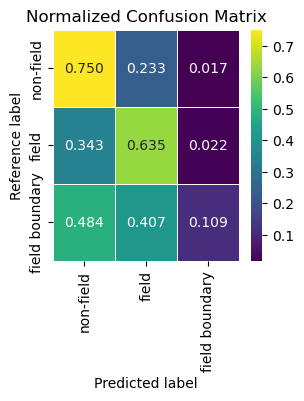

Train Loss: 0.6067 | Val Loss: 0.6574 | OA: 0.6601 | mIoU: 0.3719
  → New best model saved to /home/airg/rbalogun/ftwfieldmapper/model_out/best_model_epoch1.pth

--- Epoch 2/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:16<00:00, 39.80it/s]


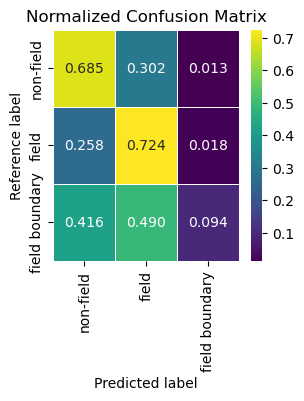

Train Loss: 0.5998 | Val Loss: 0.6577 | OA: 0.6618 | mIoU: 0.3726
  → Early stopping counter: 1/10

--- Epoch 3/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:16<00:00, 39.93it/s]


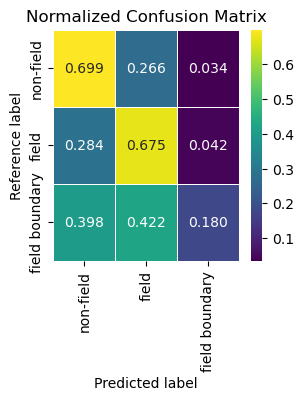

Train Loss: 0.5951 | Val Loss: 0.6544 | OA: 0.6545 | mIoU: 0.3820
  → New best model saved to /home/airg/rbalogun/ftwfieldmapper/model_out/best_model_epoch3.pth

--- Epoch 4/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 39.63it/s]


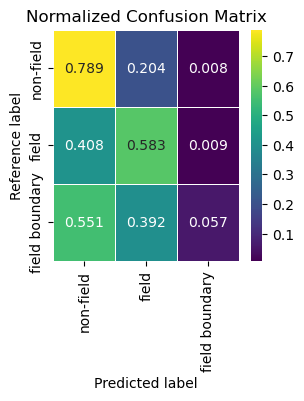

Train Loss: 0.5919 | Val Loss: 0.6749 | OA: 0.6551 | mIoU: 0.3529
  → Early stopping counter: 1/10

--- Epoch 5/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:31<00:00, 21.22it/s]


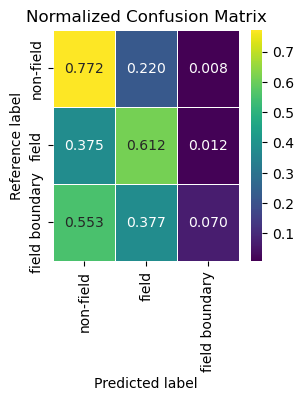

Train Loss: 0.5881 | Val Loss: 0.6686 | OA: 0.6592 | mIoU: 0.3610
  → Early stopping counter: 2/10

--- Epoch 6/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 37.92it/s]


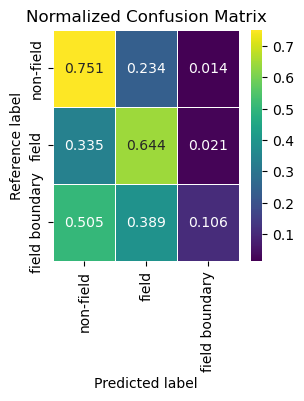

Train Loss: 0.5849 | Val Loss: 0.6530 | OA: 0.6639 | mIoU: 0.3747
  → New best model saved to /home/airg/rbalogun/ftwfieldmapper/model_out/best_model_epoch6.pth

--- Epoch 7/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:31<00:00, 21.64it/s]


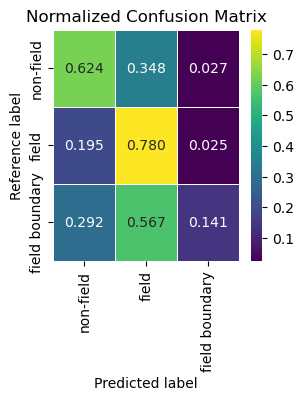

Train Loss: 0.5848 | Val Loss: 0.6626 | OA: 0.6564 | mIoU: 0.3787
  → Early stopping counter: 1/10

--- Epoch 8/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 39.28it/s]


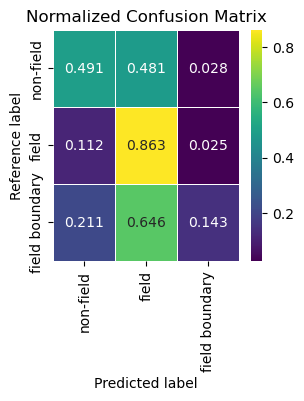

Train Loss: 0.5810 | Val Loss: 0.7175 | OA: 0.6215 | mIoU: 0.3495
  → Early stopping counter: 2/10

--- Epoch 9/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 39.65it/s]


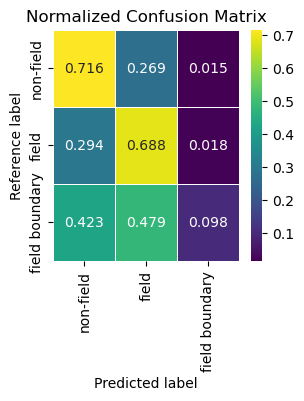

Train Loss: 0.5793 | Val Loss: 0.6542 | OA: 0.6634 | mIoU: 0.3741
  → Early stopping counter: 3/10

--- Epoch 10/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 39.49it/s]


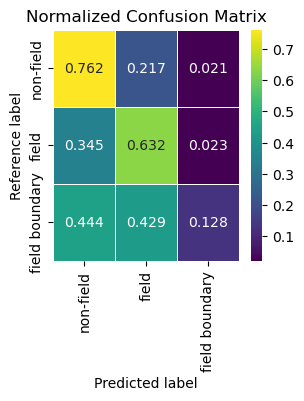

Train Loss: 0.5767 | Val Loss: 0.6456 | OA: 0.6662 | mIoU: 0.3805
  → New best model saved to /home/airg/rbalogun/ftwfieldmapper/model_out/best_model_epoch10.pth

--- Epoch 11/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 39.50it/s]


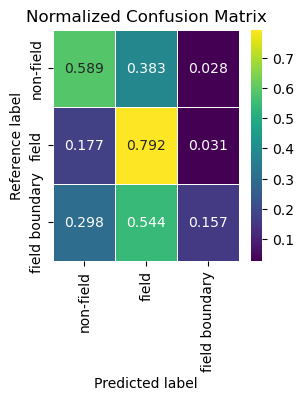

Train Loss: 0.5740 | Val Loss: 0.6639 | OA: 0.6443 | mIoU: 0.3720
  → Early stopping counter: 1/10

--- Epoch 12/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 38.16it/s]


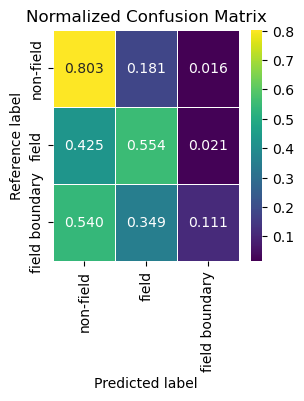

Train Loss: 0.5722 | Val Loss: 0.6632 | OA: 0.6539 | mIoU: 0.3634
  → Early stopping counter: 2/10

--- Epoch 13/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 38.86it/s]


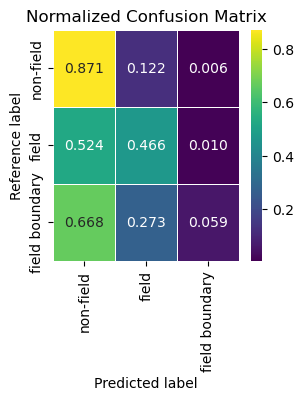

Train Loss: 0.5691 | Val Loss: 0.7116 | OA: 0.6499 | mIoU: 0.3409
  → Early stopping counter: 3/10

--- Epoch 14/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:27<00:00, 24.16it/s]


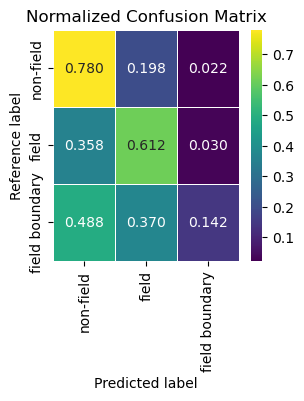

Train Loss: 0.5672 | Val Loss: 0.6480 | OA: 0.6680 | mIoU: 0.3837
  → Early stopping counter: 4/10

--- Epoch 15/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 38.26it/s]


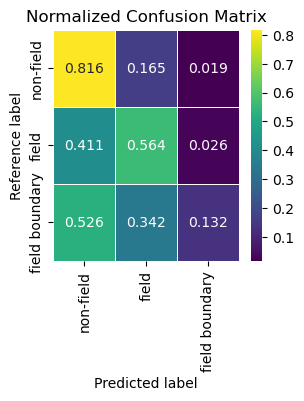

Train Loss: 0.5661 | Val Loss: 0.6479 | OA: 0.6664 | mIoU: 0.3777
  → Early stopping counter: 5/10

--- Epoch 16/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 38.84it/s]


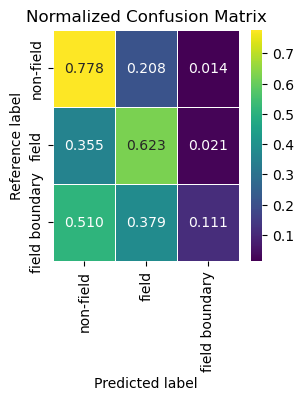

Train Loss: 0.5636 | Val Loss: 0.6473 | OA: 0.6695 | mIoU: 0.3792
  → Early stopping counter: 6/10

--- Epoch 17/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:24<00:00, 27.80it/s]


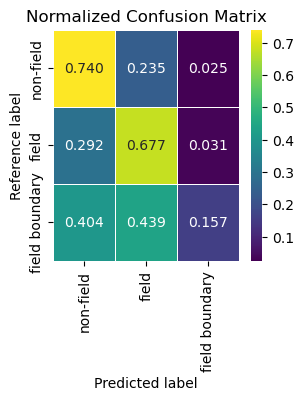

Train Loss: 0.5402 | Val Loss: 0.6493 | OA: 0.6753 | mIoU: 0.3951
  → Early stopping counter: 7/10

--- Epoch 18/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 38.32it/s]


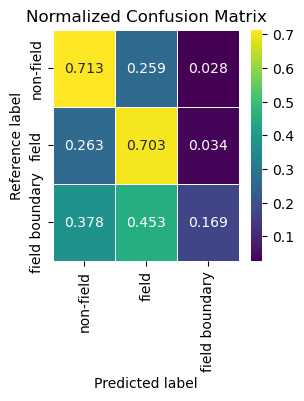

Train Loss: 0.5307 | Val Loss: 0.6551 | OA: 0.6729 | mIoU: 0.3960
  → Early stopping counter: 8/10

--- Epoch 19/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 39.37it/s]


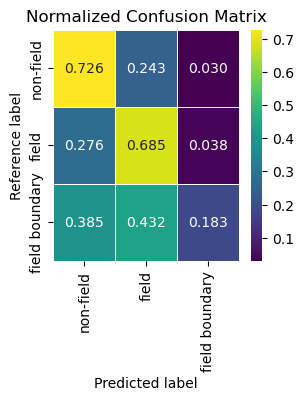

Train Loss: 0.5259 | Val Loss: 0.6554 | OA: 0.6734 | mIoU: 0.3983
  → Early stopping counter: 9/10

--- Epoch 20/50 ---


Validating: 100%|██████████████████████████████████████████████████████████| 675/675 [00:16<00:00, 39.74it/s]


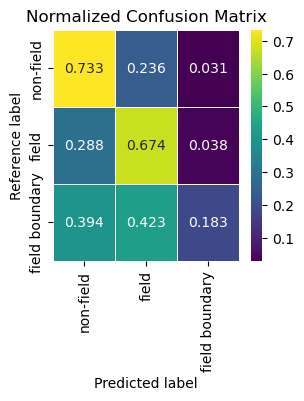

Train Loss: 0.5230 | Val Loss: 0.6602 | OA: 0.6719 | mIoU: 0.3967
  → Early stopping counter: 10/10
Early stopping triggered. Stopping training.

All training metrics saved to /home/airg/rbalogun/ftwfieldmapper/model_out/training_metrics.csv


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import os
import pandas as pd
import numpy as np


import segmentation_models_pytorch as smp
from src.lacuna.evaluate import evaluate
from src.lacuna.datatorch import ImageData


# Define loss (Dice Loss + CrossEntropy Loss)
class DiceCrossEntropyLoss(nn.Module):
    def __init__(self, weight_dice=0.5, weight_ce=0.5):
        super().__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass')
        self.ce_loss = nn.CrossEntropyLoss()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce

    def forward(self, preds, targets):
        dice = self.dice_loss(preds, targets)
        ce = self.ce_loss(preds, targets)
        return self.weight_dice * dice + self.weight_ce * ce

criterion = DiceCrossEntropyLoss()

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=params_train["learning_rate_init"])
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

# Paths
num_epochs = params_train["epoch"]
early_stopping_patience = params_train.get("early_stopping_patience", 10)
checkpoint_dir = params_train.get("model_out_dir", "./checkpoints")
metrics_log_file = os.path.join(checkpoint_dir, "training_metrics.csv")
os.makedirs(checkpoint_dir, exist_ok=True)

# Class Mapping for evaluation
class_mapping = params_train["class_mapping"]  # Must be a dict like {0: "classA", 1: "classB", ...}

# Training
best_val_loss = float("inf")
early_stopping_counter = 0
metrics_records = []

for epoch in range(1, num_epochs + 1):
    print(f"\n--- Epoch {epoch}/{num_epochs} ---")

    model.train()
    train_loss = 0.0

    for imgs, labels, mask in tqdm(train_dataloader, desc="Training"):
        imgs, labels, mask = imgs.to(device), labels.to(device), mask.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_dataloader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_dataloader, desc="Validating"):
            # imgs, labels, mask = imgs.to(device), labels.to(device), mask.to(device)
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(val_dataloader.dataset)
    scheduler.step(val_loss)

    # Evaluate using your Evaluator
    eval_metrics = evaluate(
        model=model,
        dataloader=val_dataloader,
        num_classes=3,
        class_mapping=class_mapping,
        device=device,
        buffer=params_train.get('buffer', None),
        out_name=os.path.join(checkpoint_dir, f"epoch{epoch}_metrics.csv")
    )

    epoch_metrics = {
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "overall_accuracy": eval_metrics["Overall Accuracy"],
        "mean_accuracy": eval_metrics["Mean Accuracy"],
        "mean_iou": eval_metrics["Mean IoU"],
        "mean_precision": eval_metrics["mean Precision"],
        "mean_recall": eval_metrics["mean Recall"],
        "mean_f1_score": eval_metrics["Mean F1 Score"],
    }
    metrics_records.append(epoch_metrics)

    print(
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"OA: {eval_metrics['Overall Accuracy']:.4f} | mIoU: {eval_metrics['Mean IoU']:.4f}"
    )

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_epoch{epoch}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"  → New best model saved to {checkpoint_path}")
    else:
        early_stopping_counter += 1
        print(f"  → Early stopping counter: {early_stopping_counter}/{early_stopping_patience}")

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered. Stopping training.")
        break

# Save metrics
metrics_df = pd.DataFrame(metrics_records)
metrics_df.to_csv(metrics_log_file, index=False)
print(f"\nAll training metrics saved to {metrics_log_file}")


In [13]:
   eval_metrics = evaluate(
        model=model,
        dataloader=val_dataloader,
        num_classes=3,
        class_mapping=class_mapping,
        device=device,
        buffer=params_train.get('buffer', None),
        out_name=os.path.join(checkpoint_dir, f"epoch{epoch}_metrics.csv")
    )

AttributeError: type object 'Evaluator' has no attribute 'evaluate'

In [ ]:
(train_dataloader.dataset[0][0].shape)

# val_dataloader.dataset.__len__()